In [14]:
# Import Modules
import numpy as np # For Math
import pandas as pd # For Data Structures
import matplotlib as mpl # For Plotting Tools Library
import matplotlib.pyplot as plt # For Plotting
from pylab import cm # For Colors
from astropy.timeseries import LombScargle # For Fast Fourier Transform Analysis
import pywt # For Discrete Wavelet Transform Analysis
import os # For interacting with Operating System

# import csv

In [208]:
# Path to enclosing folder with project. Alter this if you download the project to fit your system
path = '/Users/leokamgar/jupyter/APPM 3310/APPM-3310-Final-Project/'

spec_types = ['F','G','K','M']
raw_data = []

######################################################################################################################
# FILE READING #

# Repeats for all spectral types
for tp in spec_types:
    print('Opening ' + tp + ' Type Stars')
    
    # Setup Paths
    data_folder = path + 'RAW_DATA/' + tp + '_STARS/'
    raw_plot_folder = path + 'PLOTS/RAW/' + tp + '_STARS/'
    
    # Opens all files within the spectral data folders
    for filename in os.listdir(data_folder):
        if filename == '.DS_Store': continue
        
        data_file = data_folder + filename
        
        # Reads data, if error, then prints and moves on to next file
        try:
            data = pd.read_csv(data_file)
        except Exception as e: 
            print(e)
            print('Error with reading: ' + filename + ' in ' + tp + ' type stars!')
            continue
        
        # Sorts data in ascending order by Time
        data = data.sort_values(by=['MJDstart'], axis=0, ascending=True)
        
        # Determines if from IUE or HST telescope
        if 'iue' in filename:
            iue = True
        else:
            iue = False
            
######################################################################################################################
# DATA RETRIEVAL #

        # Set arrays from data set
        time = data['MJDstart']
        flux_Si3 = data[' F(Si3)']
        error_Si3 = data['  E(Si3)']
        background_Si3 = data['  B(Si3)']
        flux_N5 = data['  F(N5)']
        error_N5 = data['  E(N5)']
        background_N5 = data['  B(N5)']
        flux_C2 = data['  F(C2)']
        error_C2 = data['  E(C2)']
        background_C2 = data['  B(C2)']
        flux_Si4 = data['  F(Si4)']
        error_Si4 = data['  E(Si4)']
        background_Si4 = data['  B(Si4)']
        col_name = data['Targname']
        
######################################################################################################################
# DATA CLEANUP AND STORING #

        # Cleans up name of star
        name = col_name[1].strip()
        # Converts Julien Date (What IUE Data Represented As) to Modified Julian Date
        if iue:
            time = time - 2400000.5
            
        raw_data.append([name, "IUE" if iue else "HST", tp,time,flux_Si3,flux_N5,flux_C2,flux_Si4])
            
######################################################################################################################
# PLOTTING #
    
        mpl.rcParams['font.family'] = 'Avenir'
        plt.rcParams['font.size'] = 18
        plt.rcParams['axes.linewidth'] = 2
        plt.rcParams['figure.figsize'] = [8,2]
        colors = cm.get_cmap('tab10', 8)

        # Create figure and add axes object
        fig = plt.figure()
        ax = fig.add_axes([0, 0, 1, 1])
        fig.patch.set_facecolor('#ffffff')

        # Scatter plot with error bars
        if not iue:
            ax.errorbar(time, flux_Si3, yerr=error_Si3, fmt='o', color=colors(0), label = r'Si III')
            ax.errorbar(time, flux_N5, yerr=error_N5, fmt='o', color=colors(1), label = r'N V')
        ax.errorbar(time, flux_C2, yerr=error_C2, fmt='o', color=colors(2), label = r'C II')
        ax.errorbar(time, flux_Si4, yerr=error_Si4, fmt='o', color=colors(3), label = r'Si IV')

        # Set tick formatting
        ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='inout')
        ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='inout')
        ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='inout')
        ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='inout')

        # Title the plot and axes
        if iue:
            ax.set_title('IUE Ion Fluxes of ' + name, y=1.05)
        else:
            ax.set_title('HST Ion Fluxes of ' + name, y=1.05)
        ax.set_xlabel('Modified Julian Date (days)', labelpad=10)
        ax.set_ylabel('Flux ($\\frac{erg}{cm^2 * s}$)', labelpad=10)

        ax.legend(bbox_to_anchor=(1, 1), loc=1, frameon=True, fontsize=16)
        
        # Save plot
        if not iue:
            plt.savefig(raw_plot_folder + 'HST_' + name + '.png', transparent=False, bbox_inches='tight')
        else:
            plt.savefig(raw_plot_folder + 'IUE_' + name + '.png', transparent=False, bbox_inches='tight')
            
        # Show plot
#         plt.show()

        # Close Plot
        plt.close()

######################################################################################################################

Opening F Type Stars
Opening G Type Stars
Opening K Type Stars
Opening M Type Stars


In [207]:
######################################################################################################################
# Fast Fourier Transform to Compare #

# raw_data[n] format:
# [0: name, 1: telescope, 2: spectral type, 3: time (x-axis), 4: Si3 flux, 5: N5 flux, 6: C2 flux, 7: Si4 flux]

fft_data = []

for n in range(len(raw_data)):
    
    fft_plot_folder = path + 'PLOTS/FFT/' + raw_data[n][2] + '_STARS/'
    
    # Perform FFT using Lomb Scargle Periodogram Analysis package
    frequencySi3, powerSi3 = LombScargle(raw_data[n][3], raw_data[n][4]).autopower()
    frequencyN5, powerN5 = LombScargle(raw_data[n][3], raw_data[n][5]).autopower()
    frequencyC2, powerC2 = LombScargle(raw_data[n][3], raw_data[n][6]).autopower()
    frequencySi4, powerSi4 = LombScargle(raw_data[n][3], raw_data[n][7]).autopower()
    
    # Storing FFT data
    fft_data.append([raw_data[n][0], raw_data[n][1], raw_data[n][2], frequencySi3, powerSi3, frequencyN5, powerN5, frequencyC2, powerC2, frequencySi4, powerSi4])

    if 'HST' == raw_data[n][1]:
        fig, axs = plt.subplots(2, 2, figsize=(12,11), constrained_layout = True)
        fig.suptitle(f'{raw_data[n][1]} {raw_data[n][0]} Lomb Scargle Periodogram Analysis', fontsize=25)
        plt.rcParams['figure.figsize'] = [8,8]
        fig.patch.set_facecolor('#f8f8f8')
        
        axs[0, 0].plot(frequencySi3, powerSi3, color=colors(0), label='Si III')
        axs[0, 0].legend()
        axs[0, 0].set_title('Power vs Period')
        axs[0, 0].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[0, 0].set_xlim([min(frequencySi3), max(frequencySi3)])
        axs[0, 1].plot(frequencyN5, powerN5, color=colors(1), label='N V')
        axs[0, 1].legend()
        axs[0, 1].yaxis.set_label_position("right")
        axs[0, 1].yaxis.tick_right()
        axs[0, 1].set_title('Power vs Period')
        axs[0, 1].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[0, 1].set_xlim([min(frequencyN5), max(frequencyN5)])
        axs[1, 0].plot(frequencyC2, powerC2, color=colors(2), label='C II')
        axs[1, 0].legend()
        axs[1, 0].set_title('Power vs Period')
        axs[1, 0].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[1, 0].set_xlim([min(frequencyC2), max(frequencyC2)])
        axs[1, 1].plot(frequencySi4, powerSi4, color=colors(3), label='Si IV')
        axs[1, 1].legend()
        axs[1, 1].yaxis.set_label_position("right")
        axs[1, 1].yaxis.tick_right()
        axs[1, 1].set_title('Power vs Period')
        axs[1, 1].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[1, 1].set_xlim([min(frequencySi4), max(frequencySi4)])
        
        # Save plot
        plt.savefig(fft_plot_folder + 'HST_' + raw_data[n][0] + '.png', transparent=False, bbox_inches='tight')
        
        # Show plot
#         plt.show()
        
        # Close plot
        plt.close()
    else: 
        fig, axs = plt.subplots(1, 2, figsize=(12,5.5), constrained_layout = True)
        fig.suptitle(f'{raw_data[n][1]} {raw_data[n][0]} Lomb Scargle Periodogram Analysis', fontsize=25)
        plt.rcParams['figure.figsize'] = [4,8]
        fig.patch.set_facecolor('#f8f8f8')

        axs[0].plot(frequencyC2, powerC2, color=colors(2), label='C II')
        axs[0].legend()
        axs[0].set_title('Power vs Period')
        axs[0].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[0].set_xlim([min(frequencyC2), max(frequencyC2)])
        axs[1].plot(frequencySi4, powerSi4, color=colors(3), label='Si IV')
        axs[1].legend()
        axs[1].yaxis.set_label_position("right")
        axs[1].yaxis.tick_right()
        axs[1].set_title('Power vs Period')
        axs[1].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[1].set_xlim([min(frequencySi4), max(frequencySi4)])

        # Save plot
        plt.savefig(fft_plot_folder + 'IUE_' + raw_data[n][0] + '.png', transparent=False, bbox_inches='tight')
        
        # Show plot
#         plt.show()
        
        # Close plot
        plt.close()

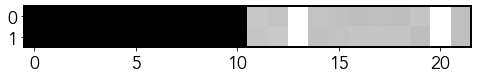

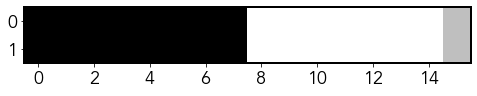

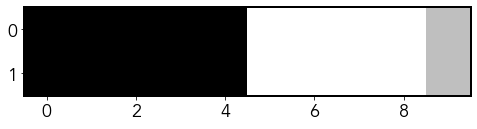

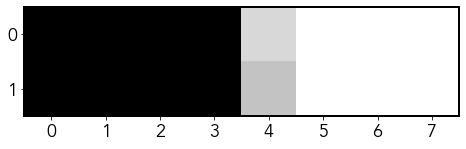

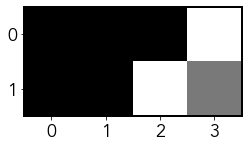

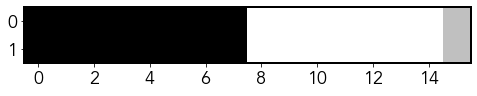

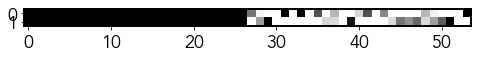

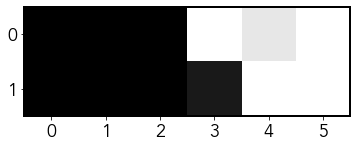

In [204]:
######################################################################################################################
# Wavelet Transform #

# Scales flux so data loss is minimized
scale = 10e13

for n in range(len(raw_data)):
    wavelet_plot_folder = path + 'PLOTS/WAVELET/' + raw_data[n][2] + '_STARS/'
    w = 'haar'
    l = 1
    
    if raw_data[n][1] == 'HST':
        coeffs_Si3 = pywt.wavedec2(np.array([raw_data[n][3],scale * raw_data[n][4]]), w, level=l)
        arr_Si3, coeff_slices_Si3 = pywt.coeffs_to_array(coeffs_Si3)
        plt.imshow(arr_Si3,cmap='gray_r',vmin=-0.25,vmax=0.75)
        plt.rcParams['figure.figsize'] = [8,2]
#         fig=plt.figure(figsize=(8,2))
        plt.show()

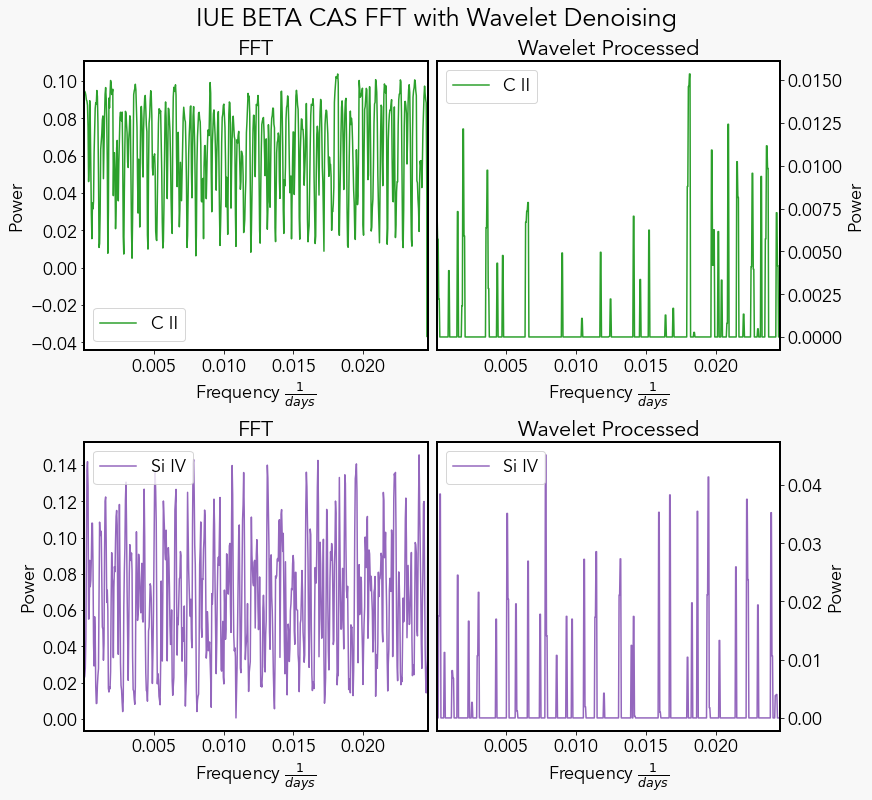

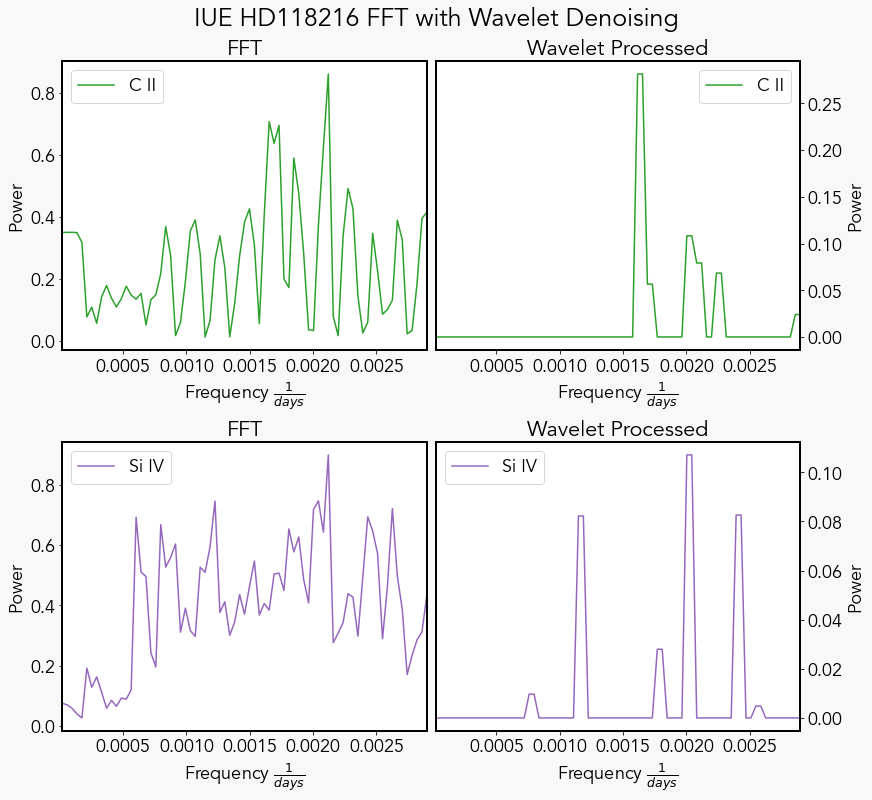

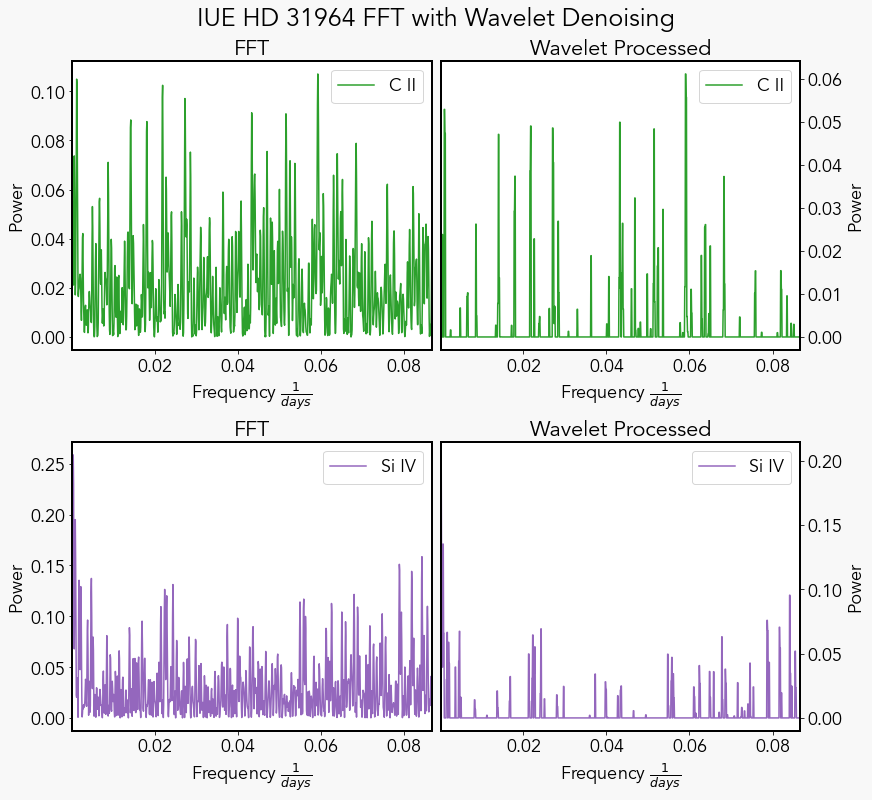

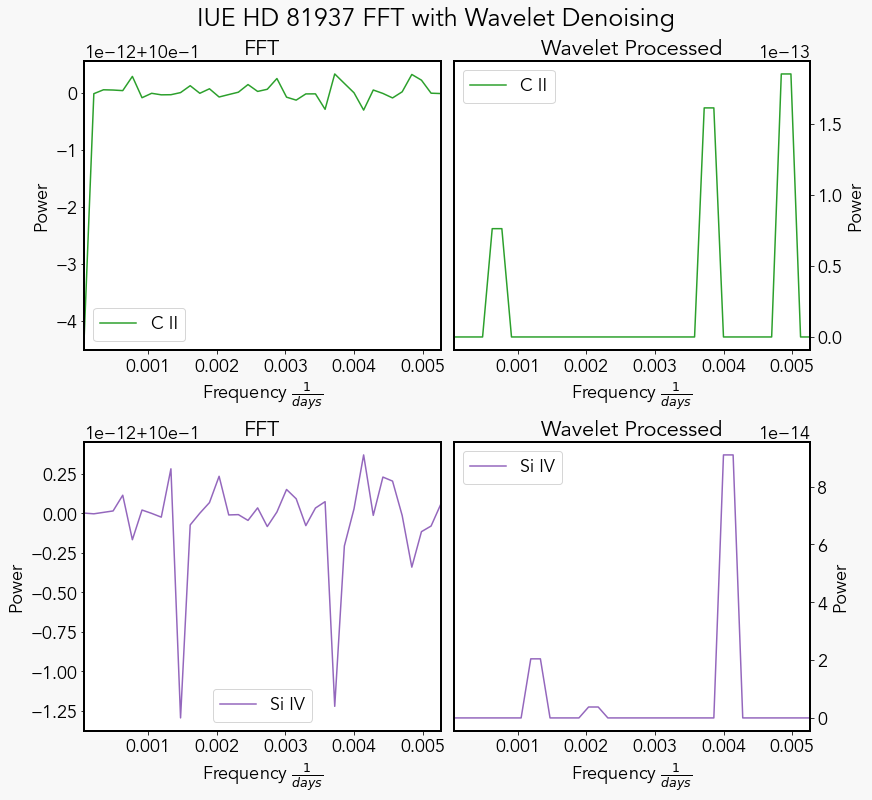

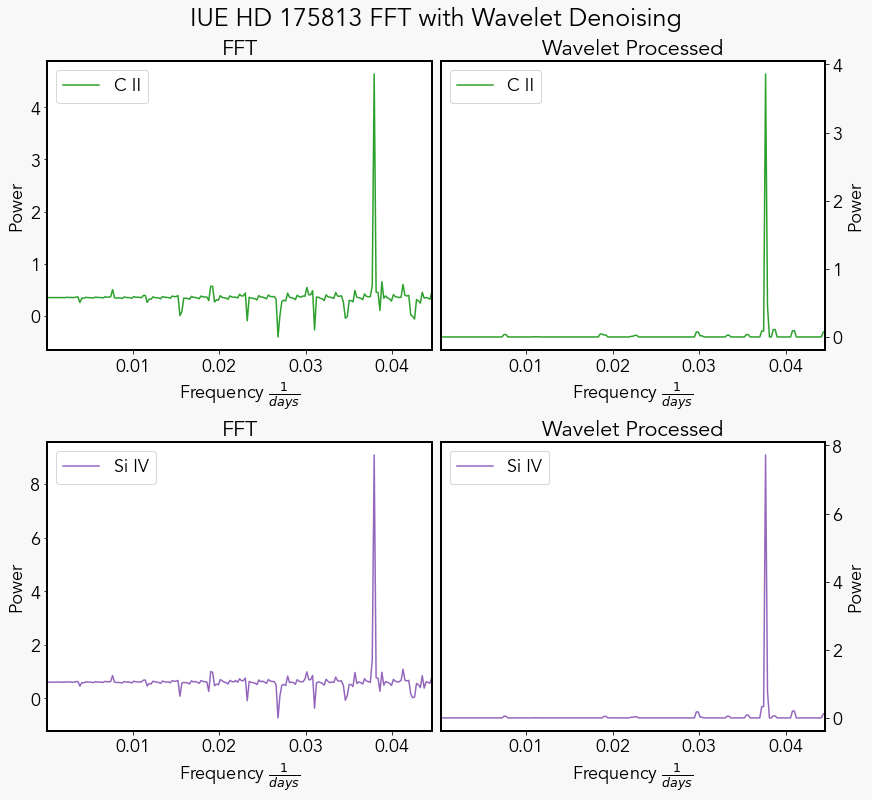

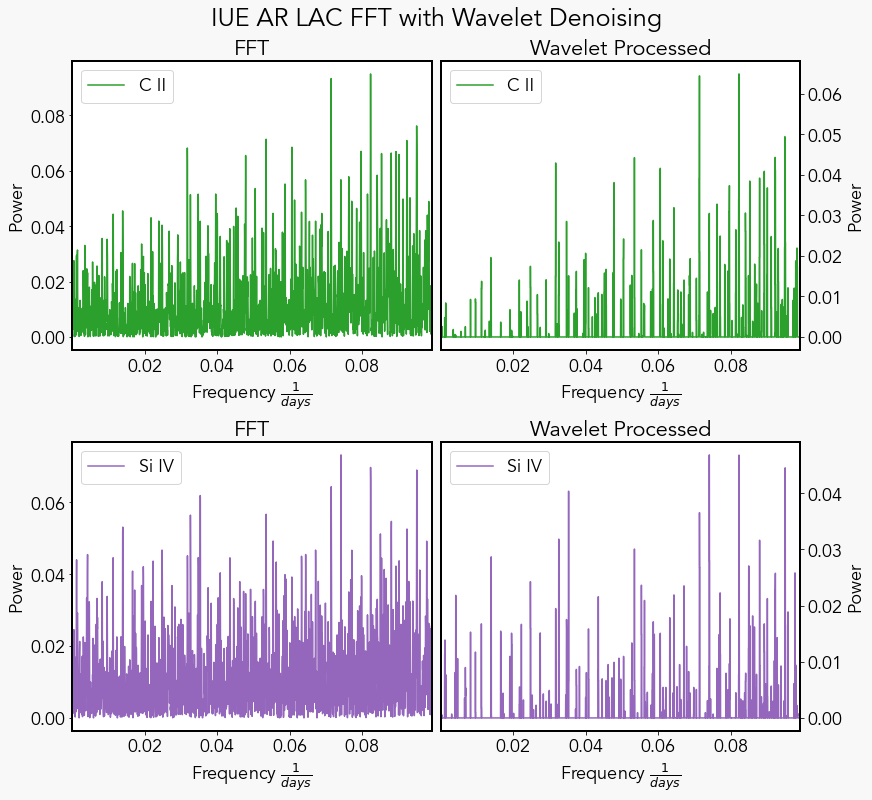

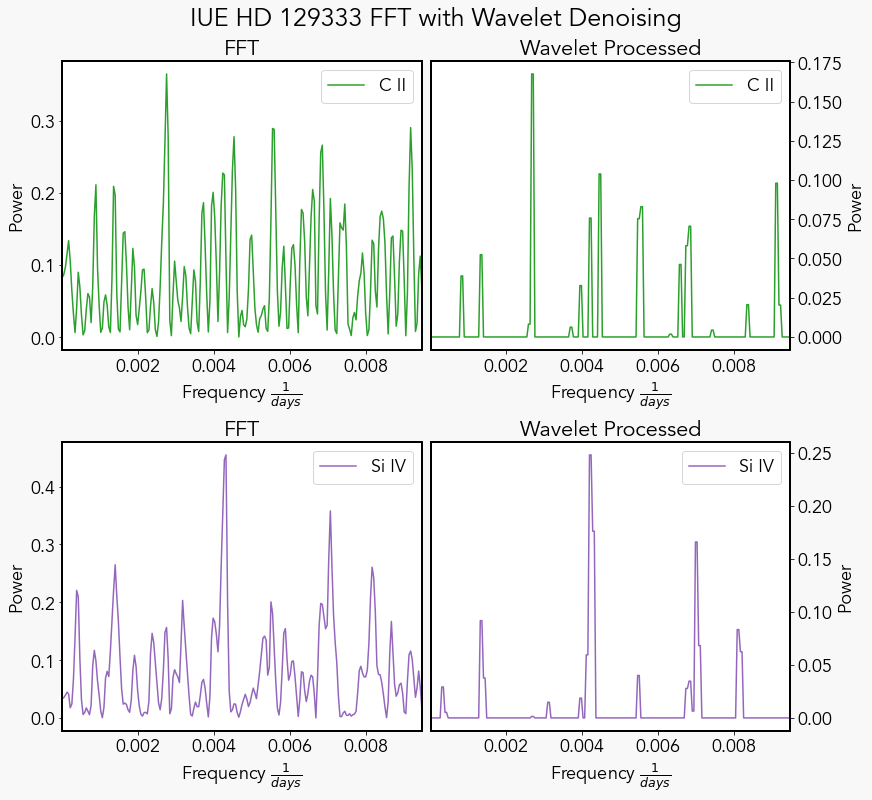

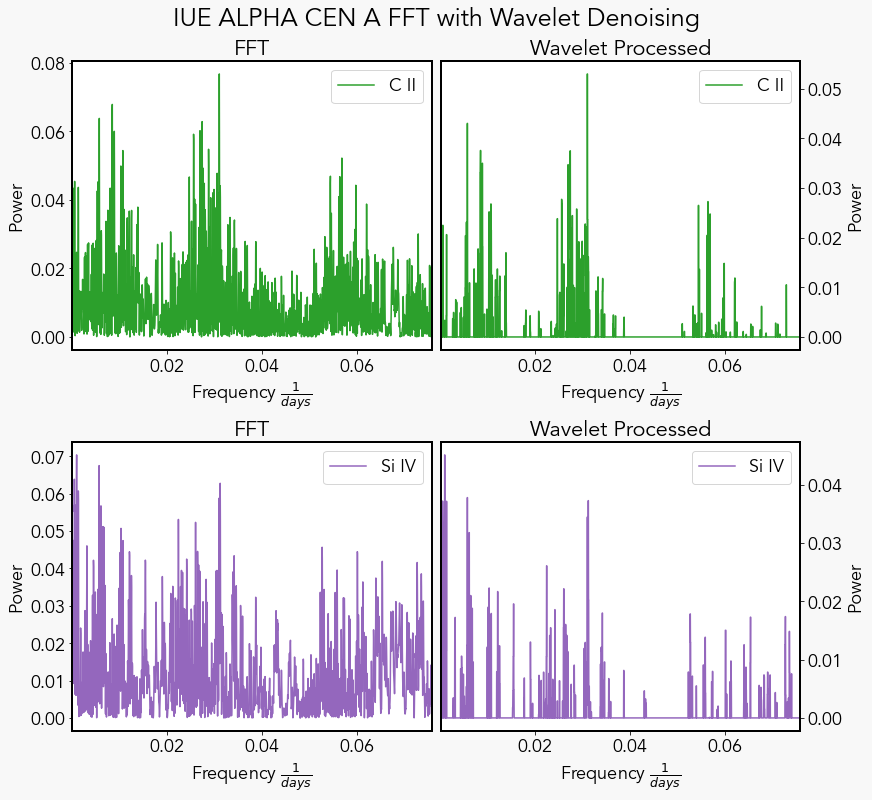

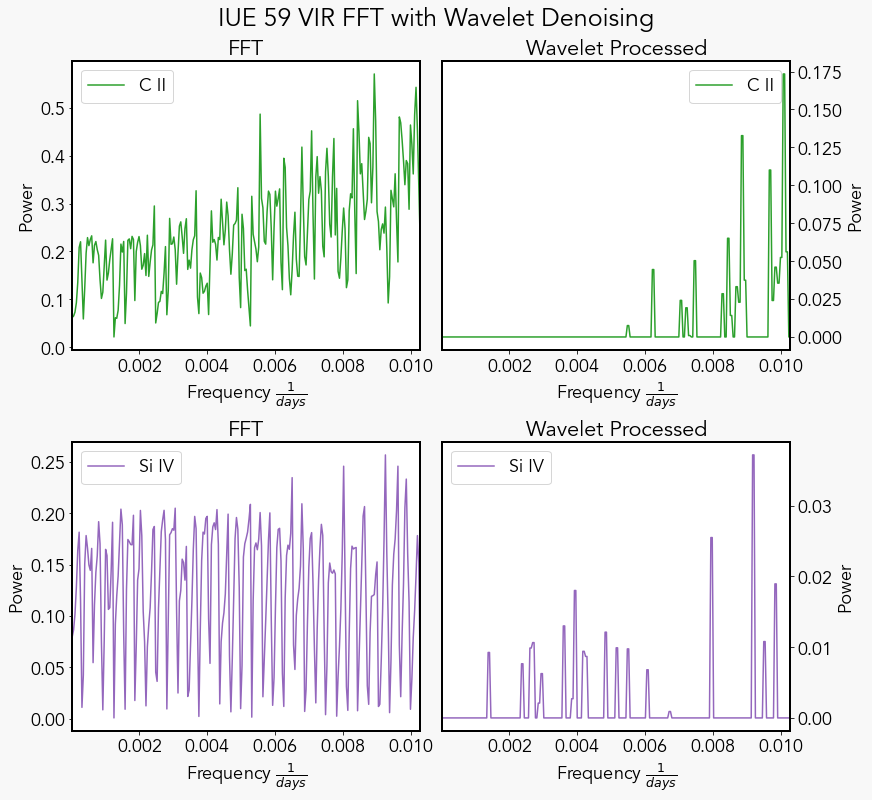

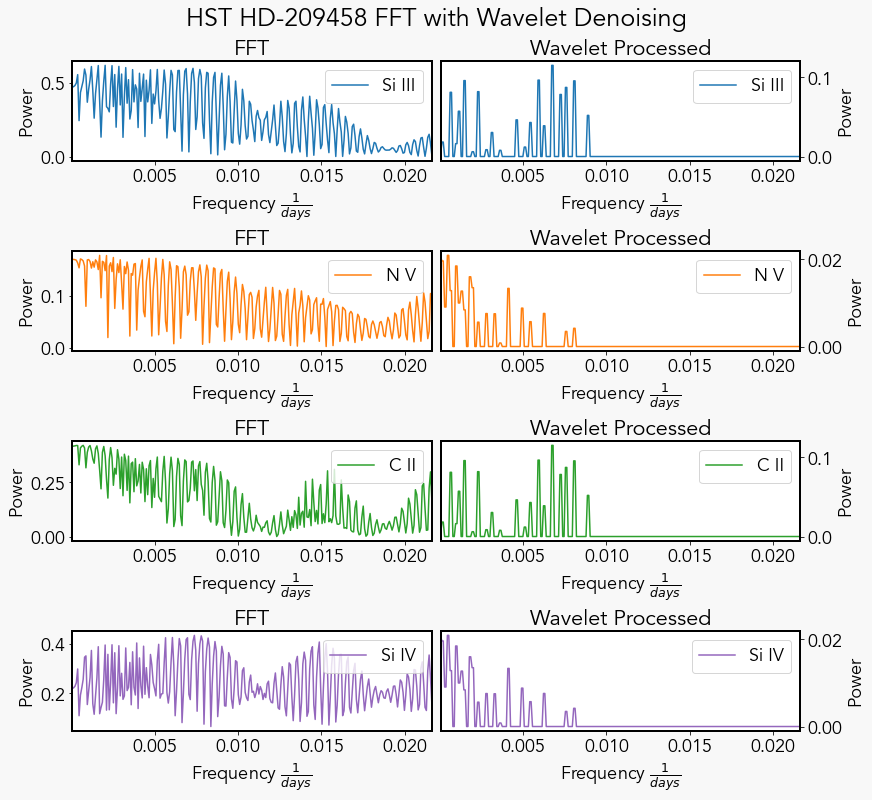

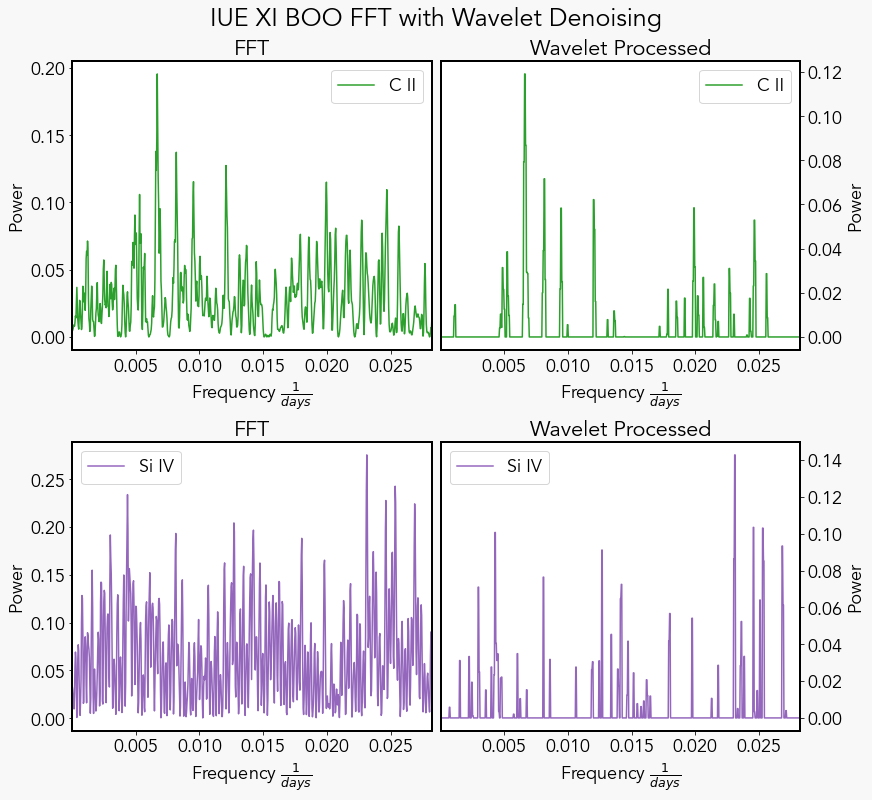

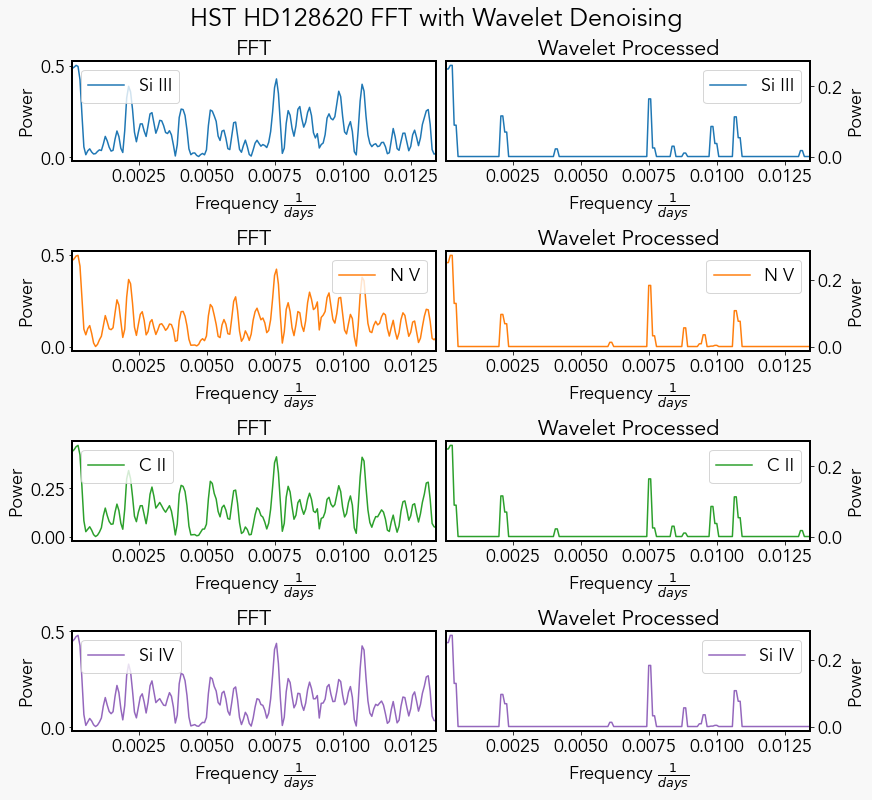

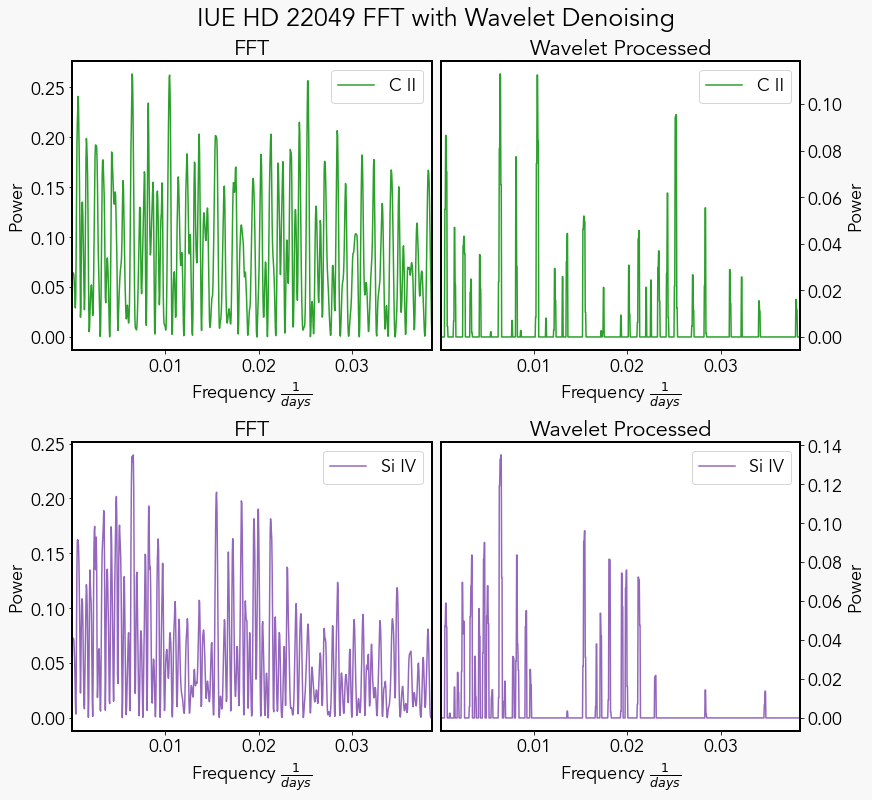

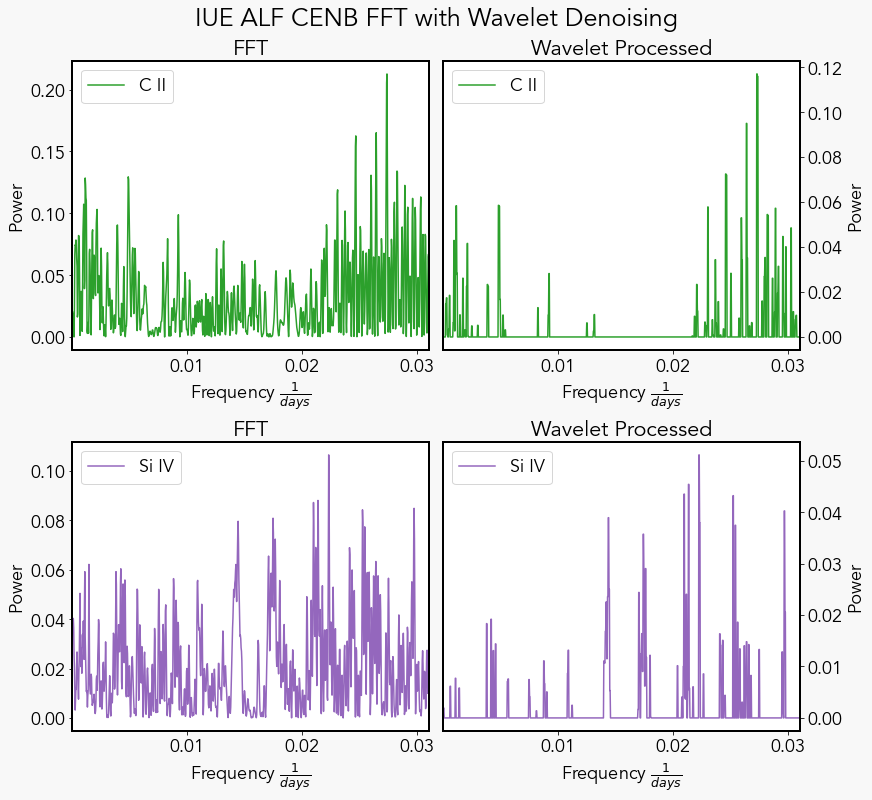

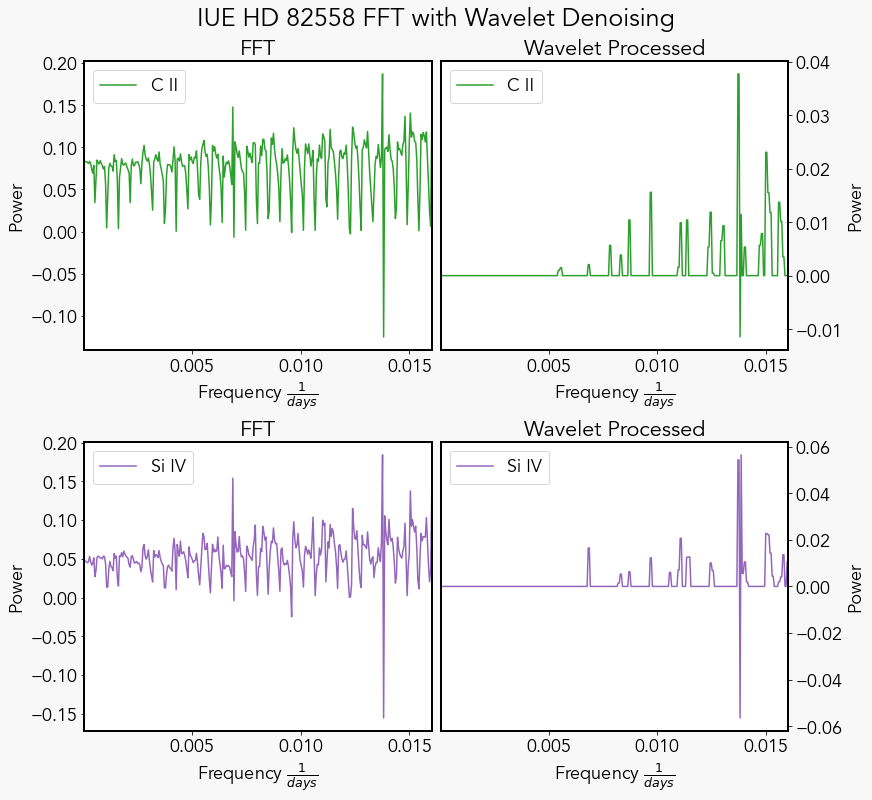

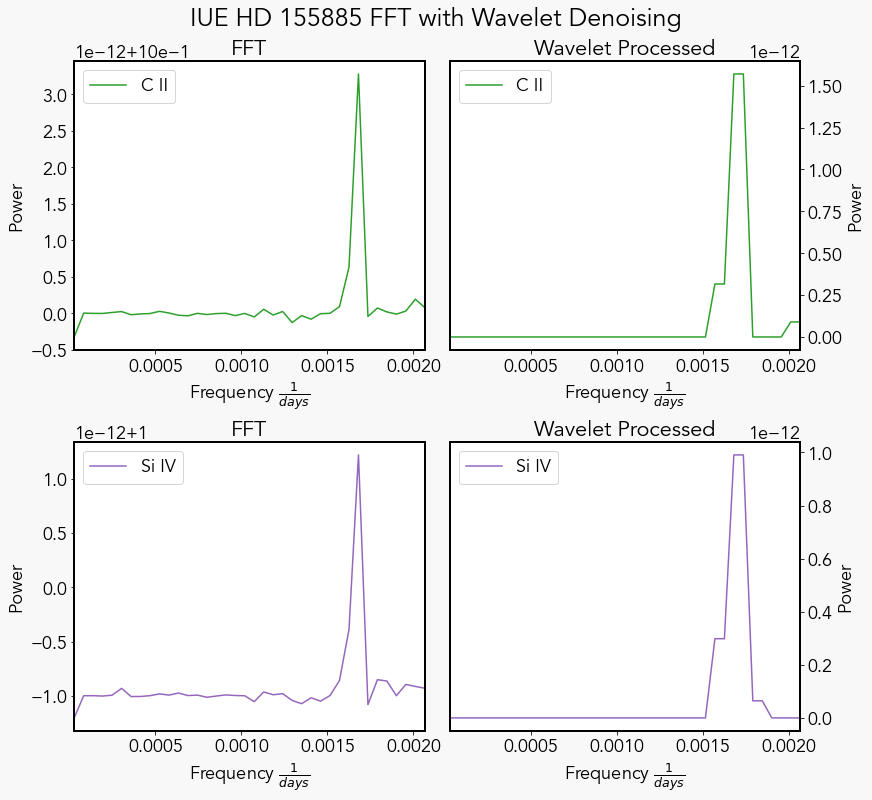

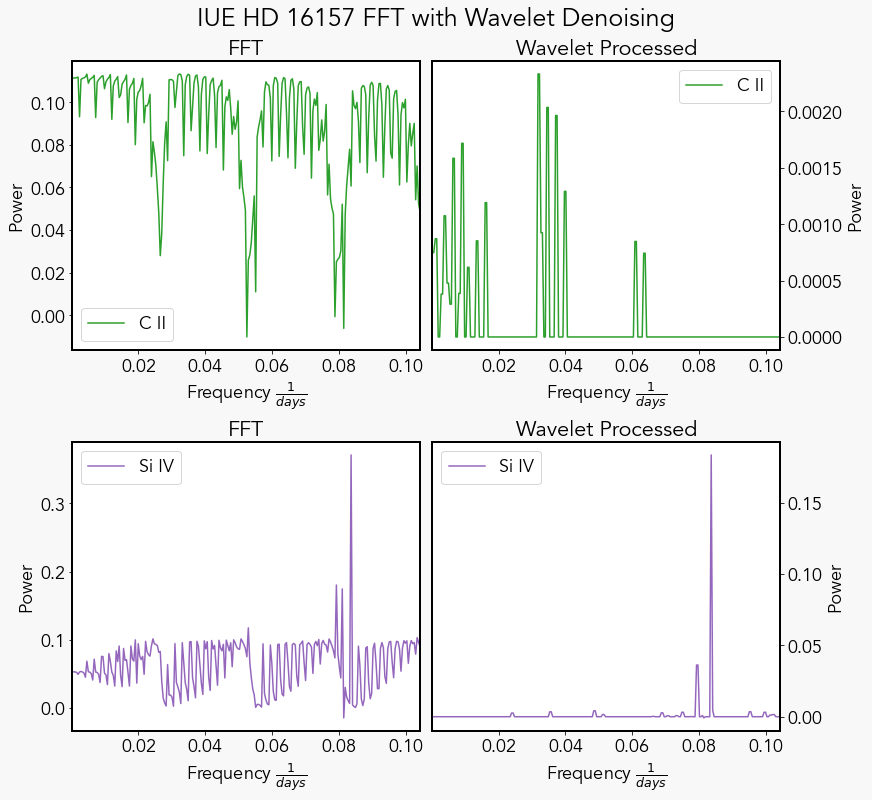

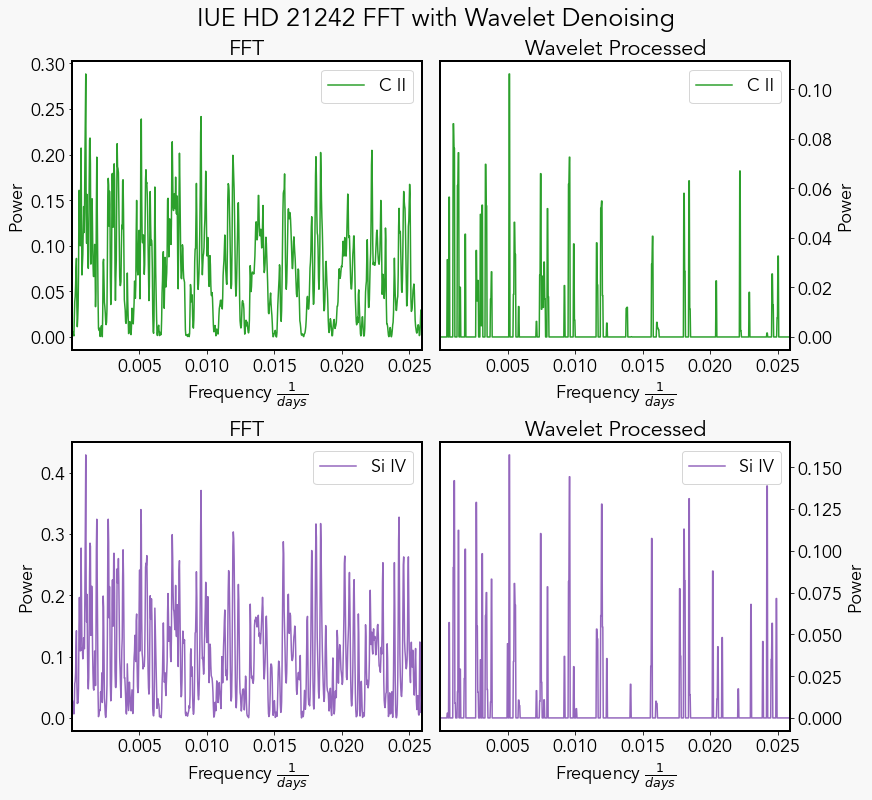

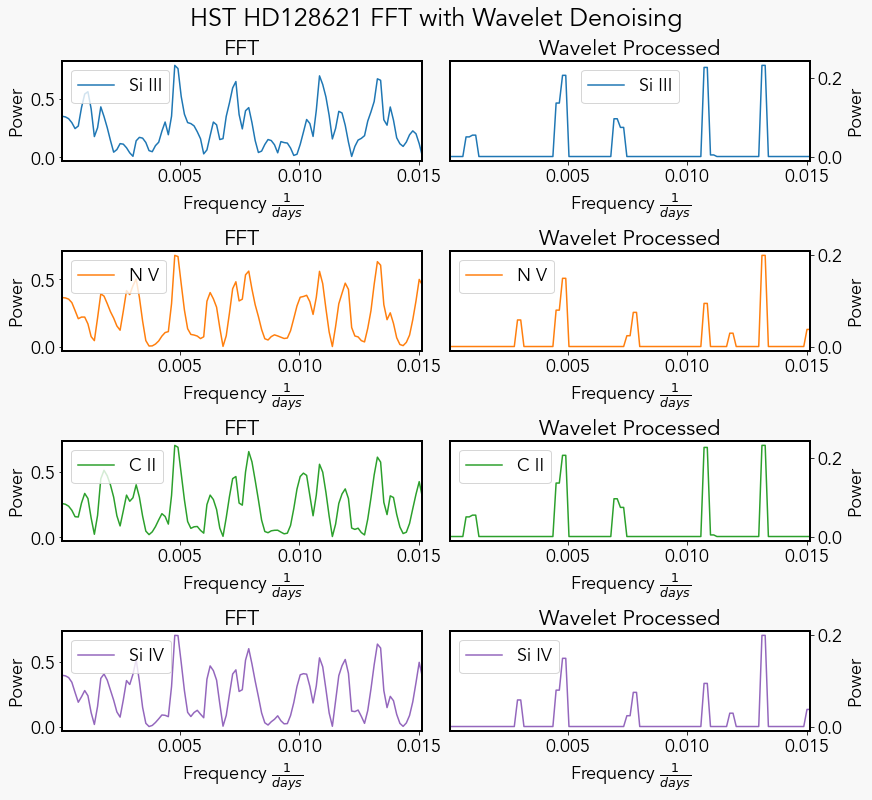

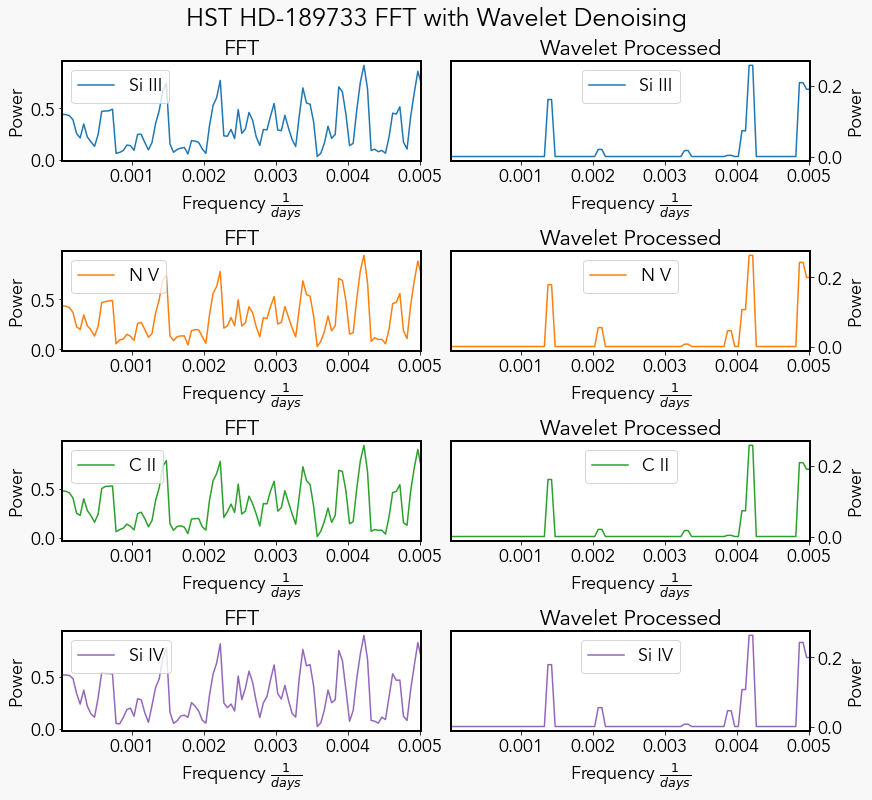

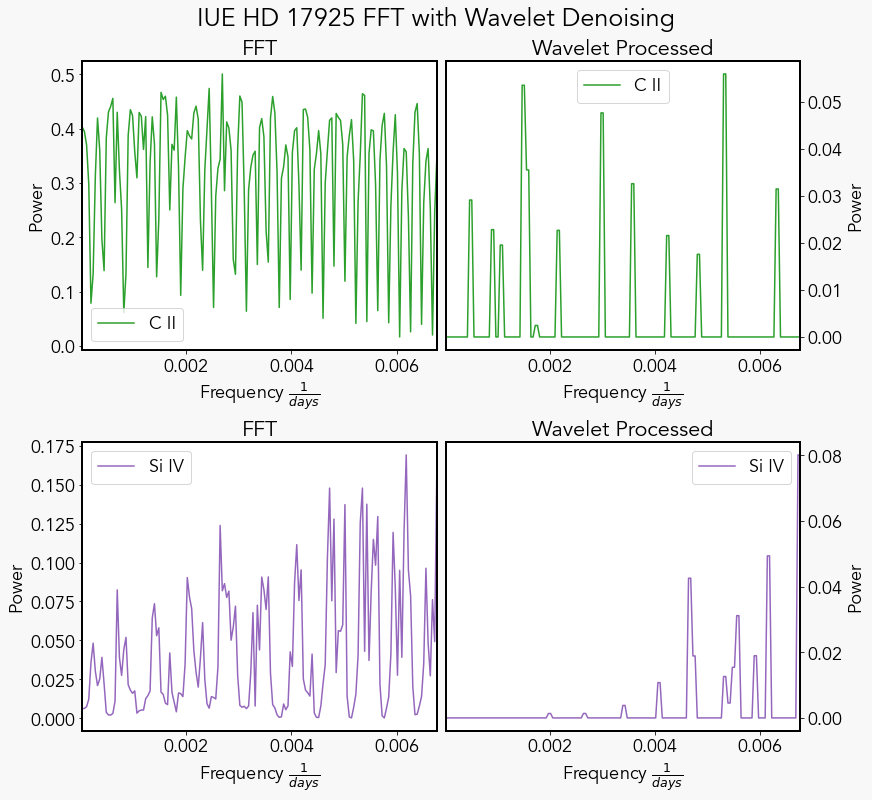

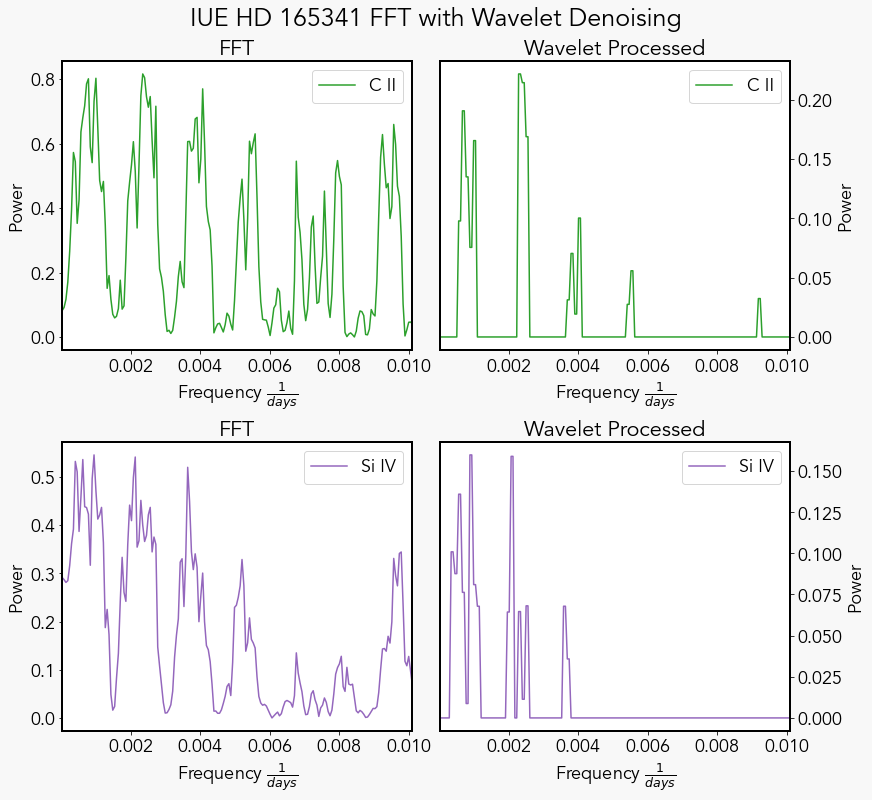

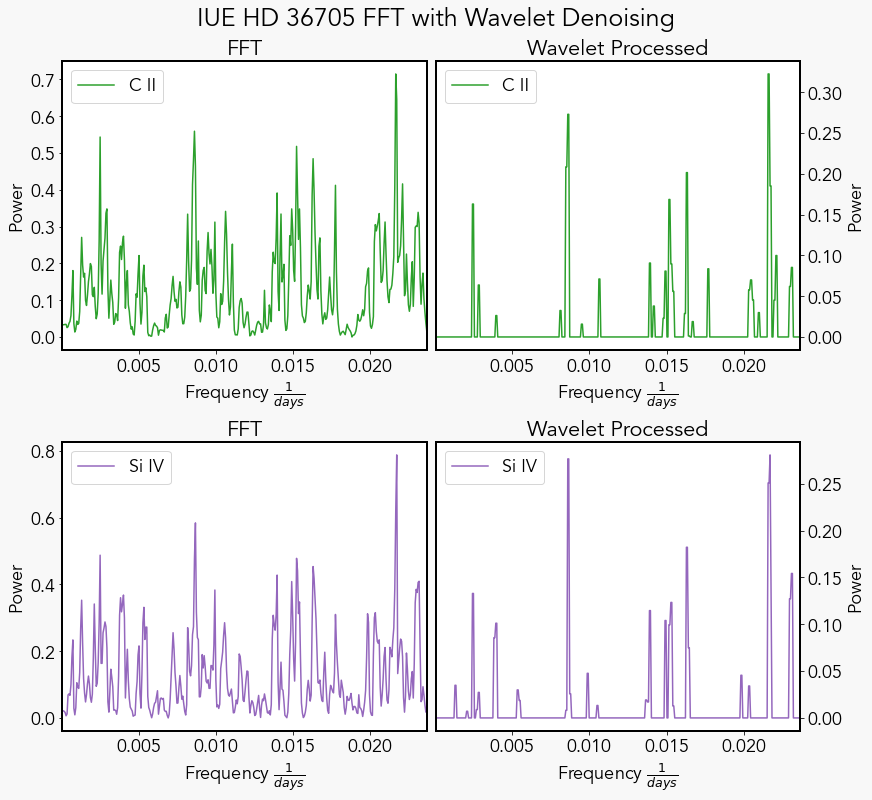

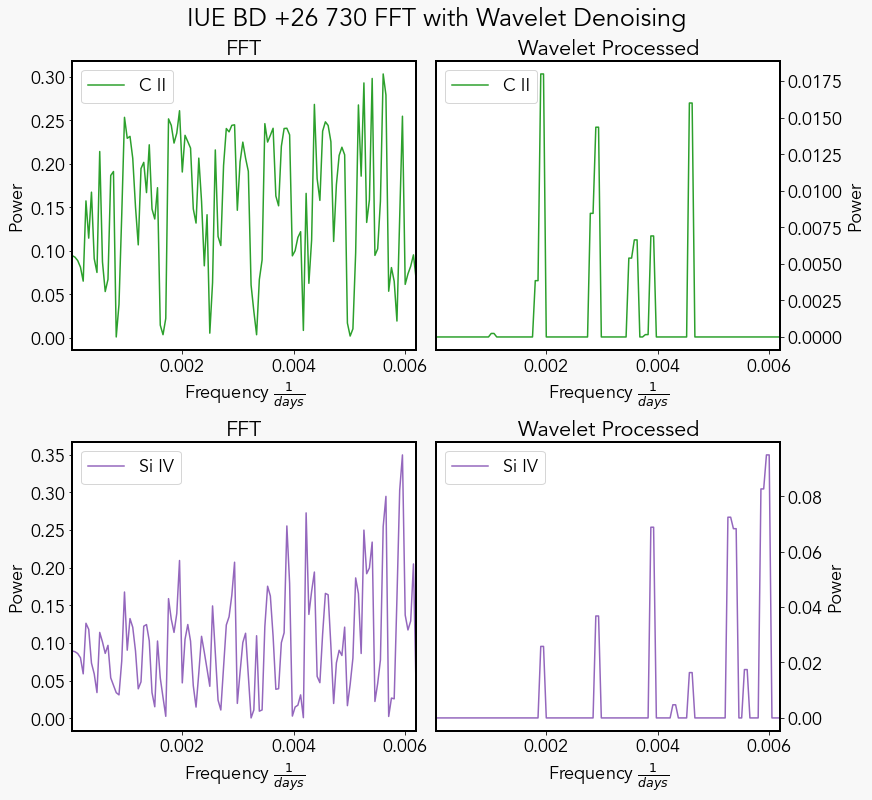

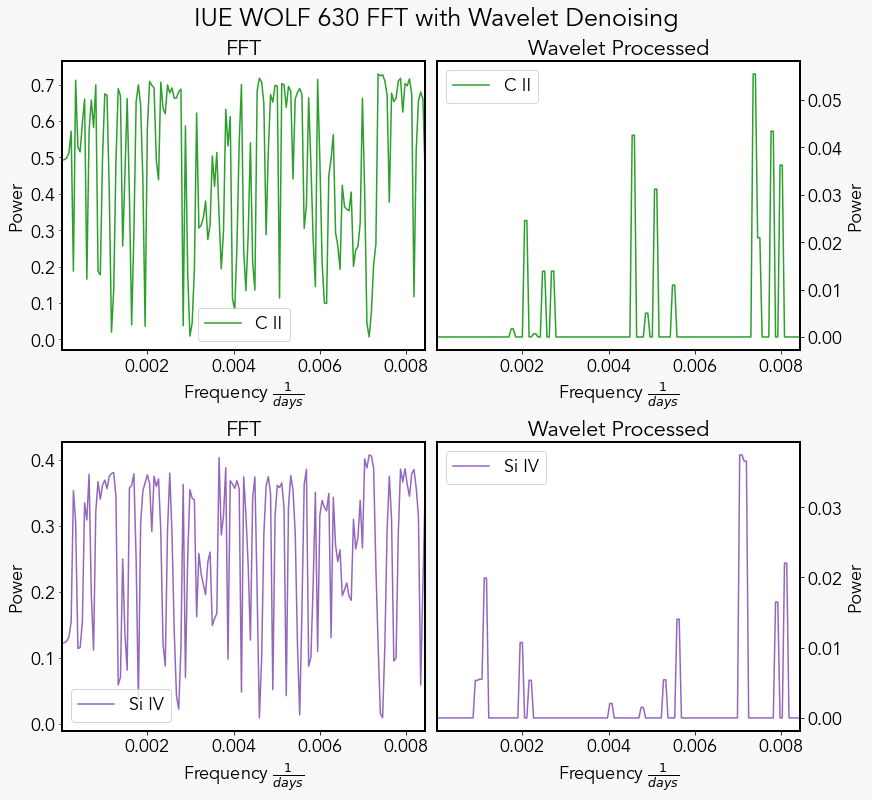

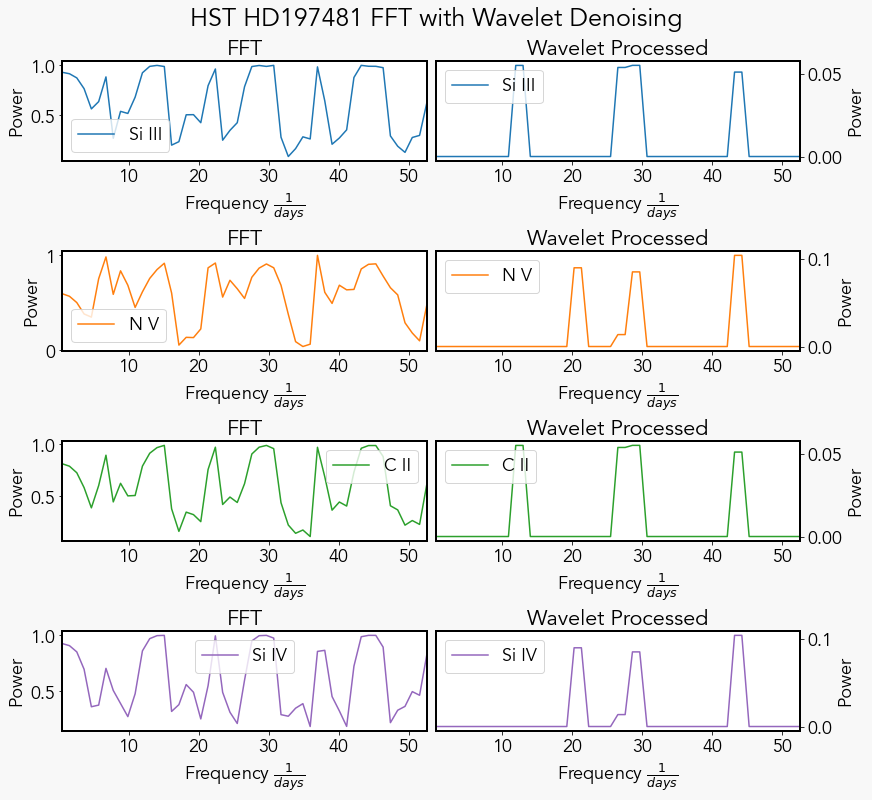

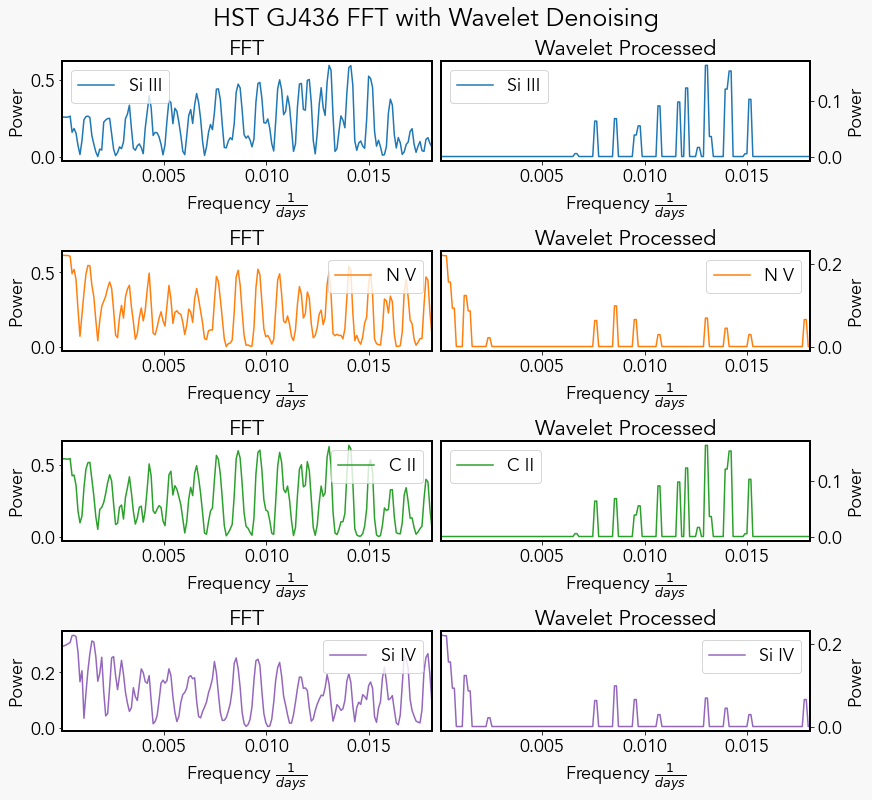

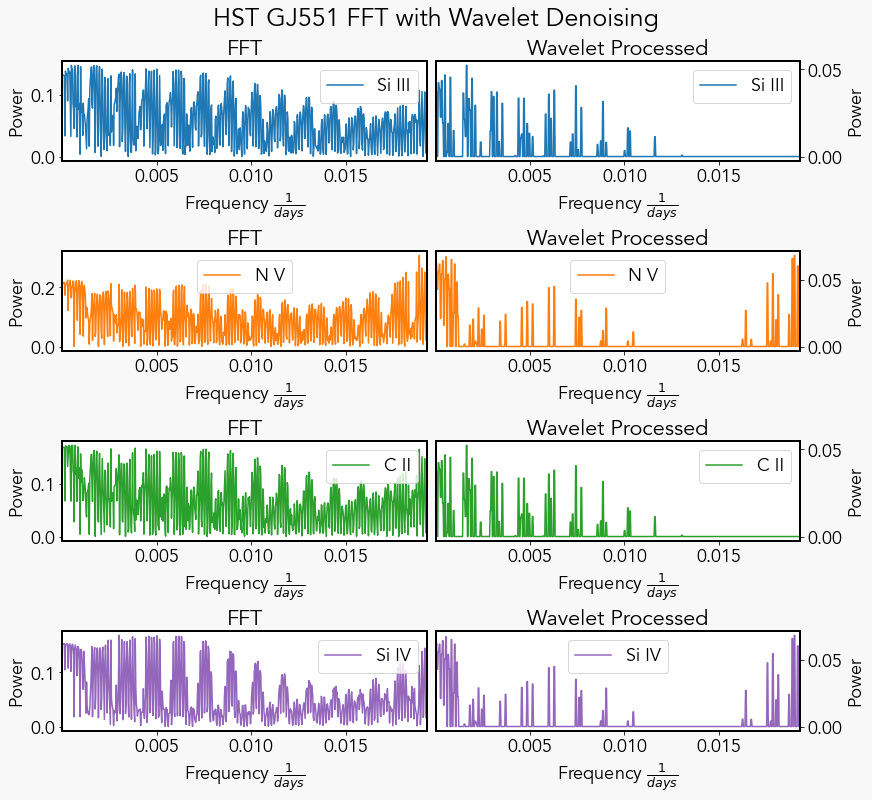

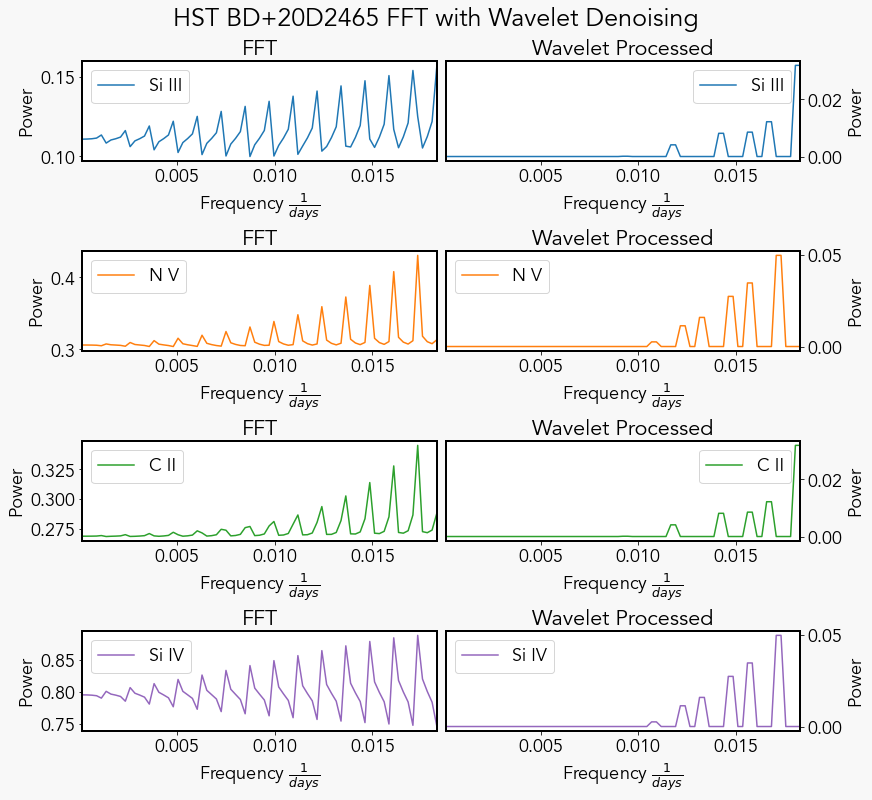

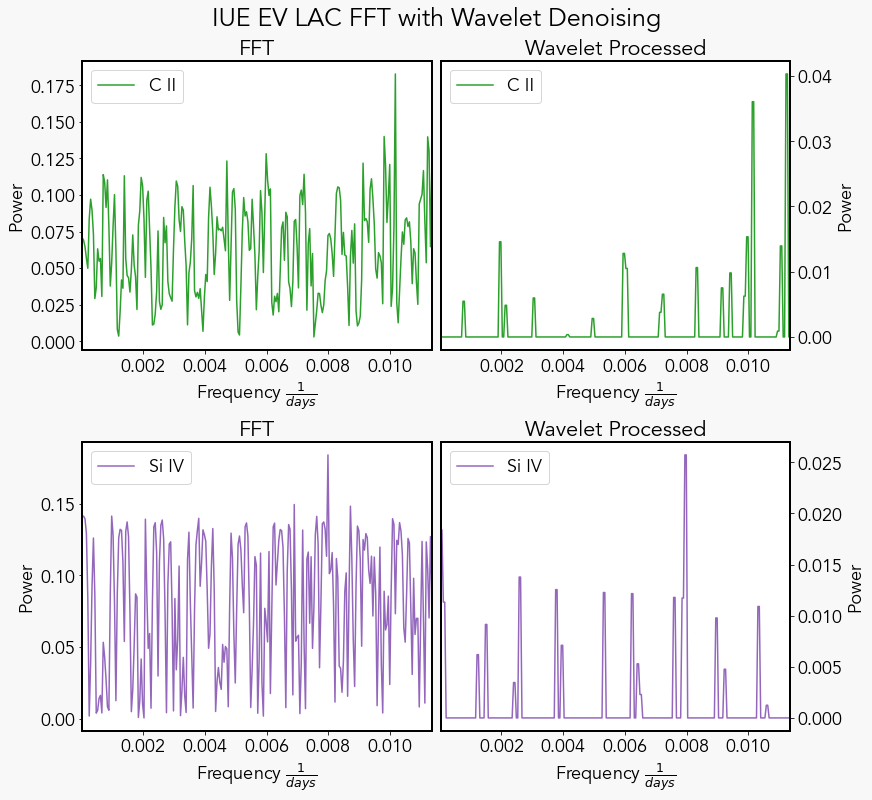

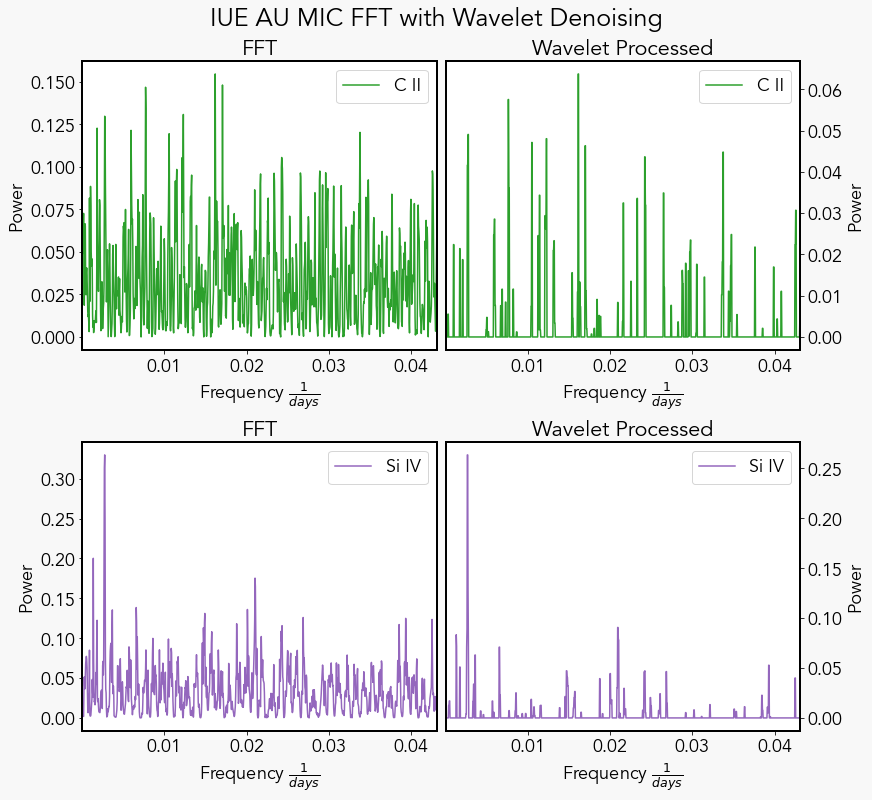

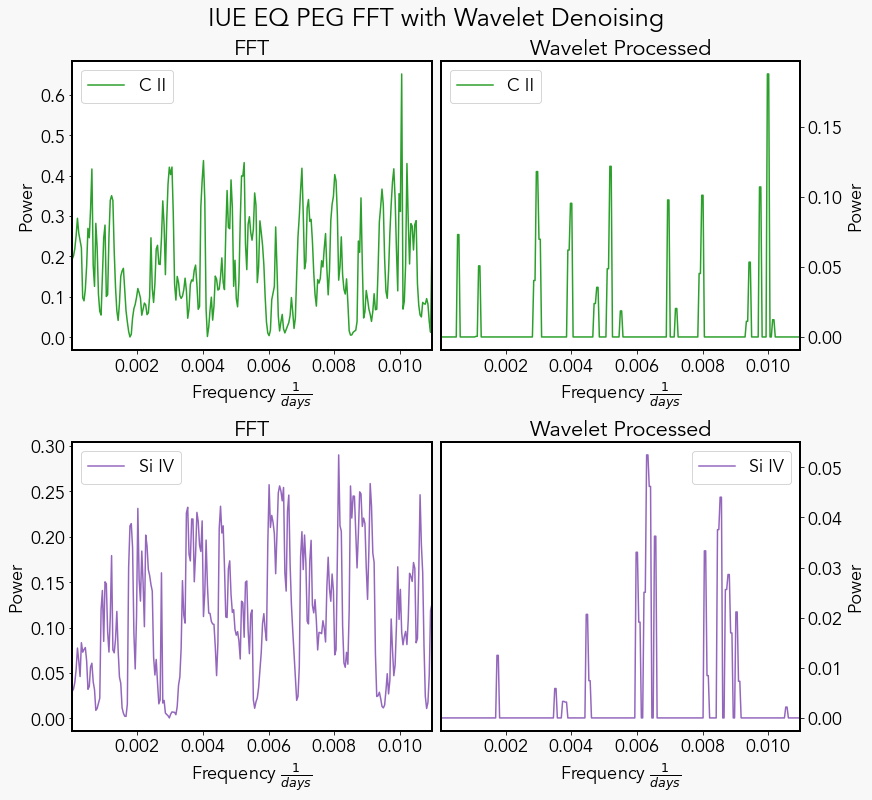

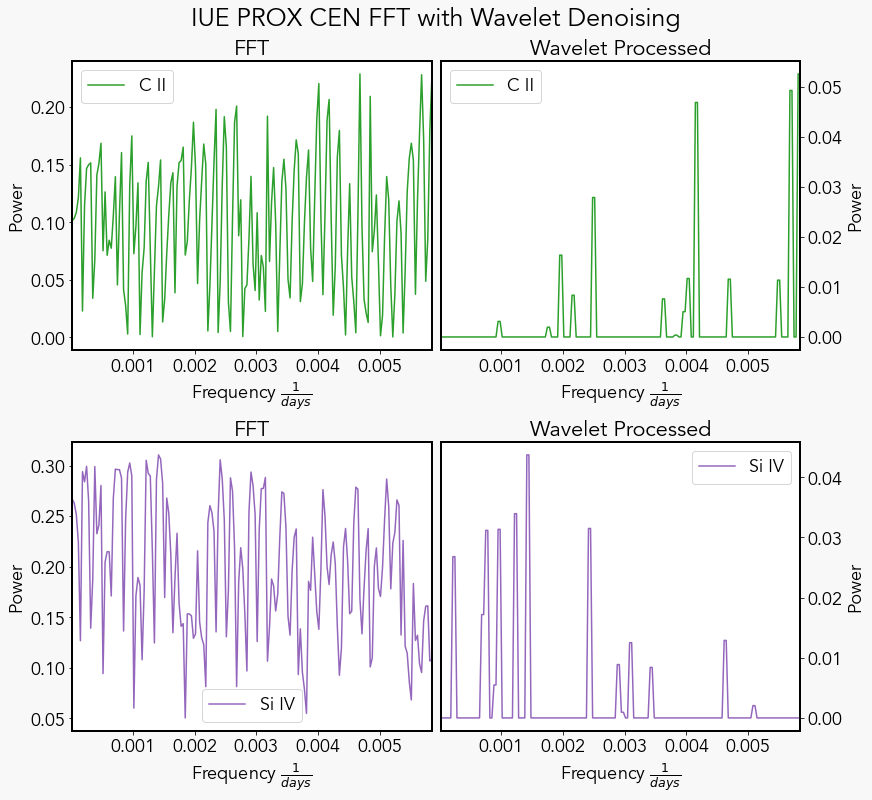

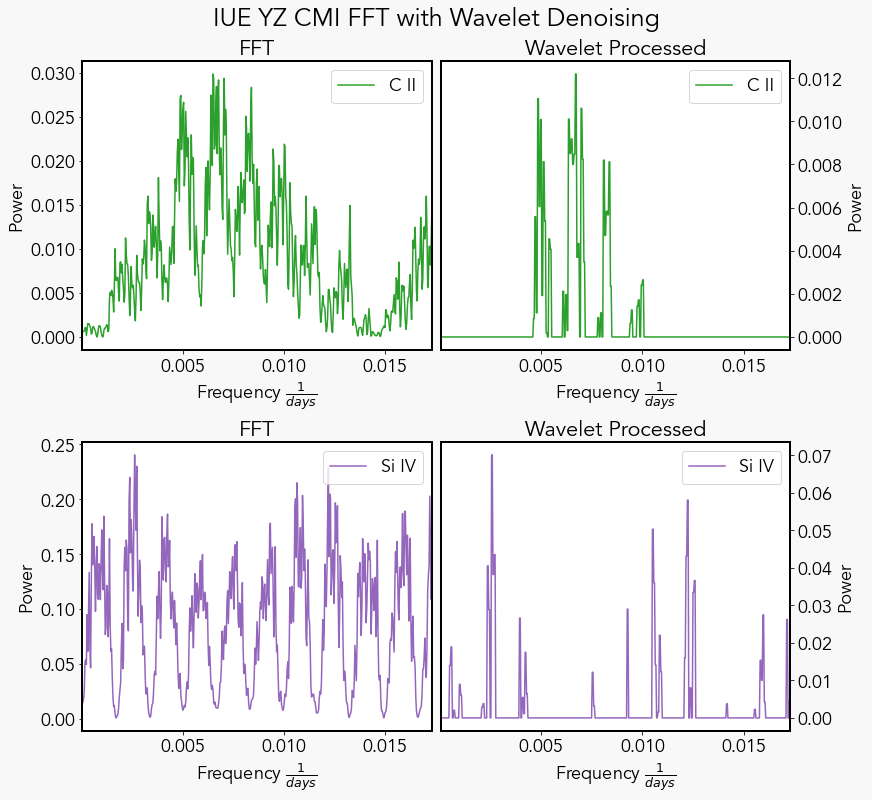

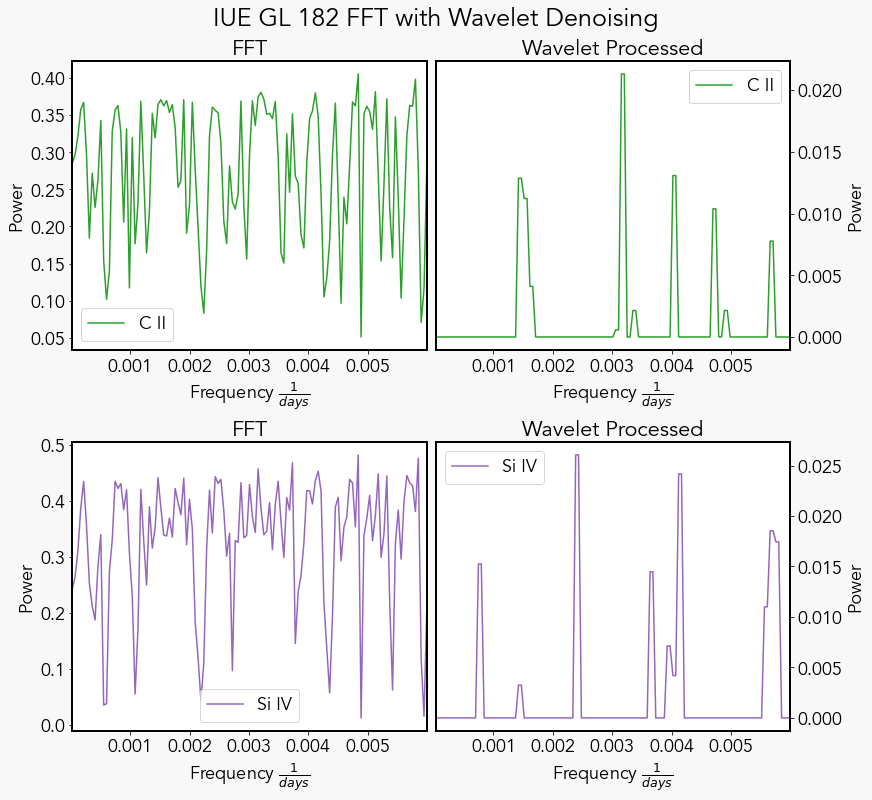

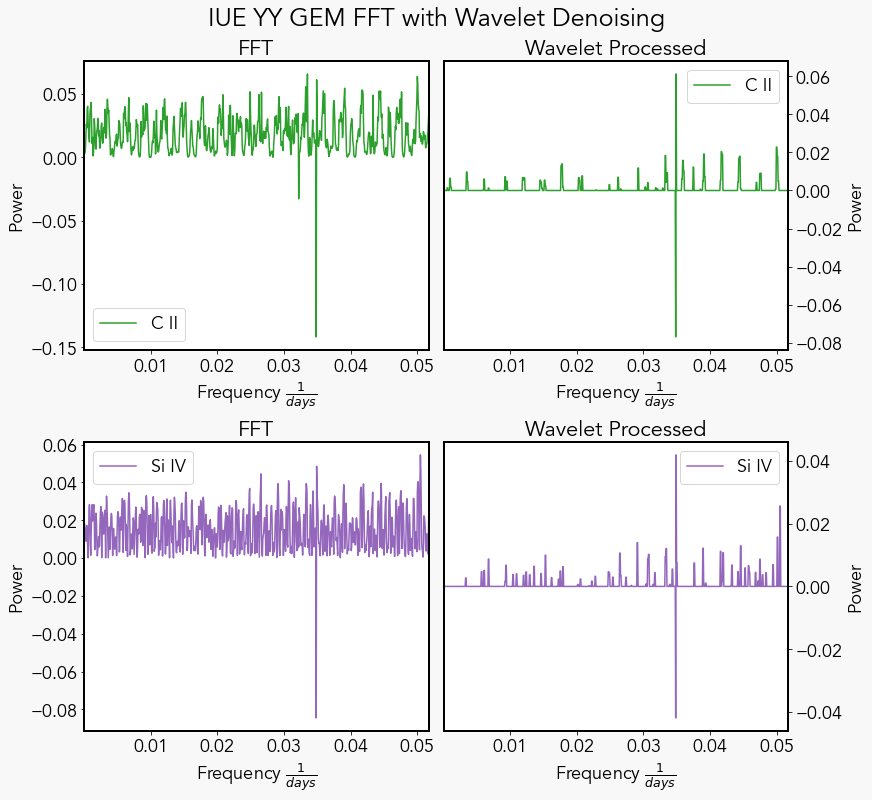

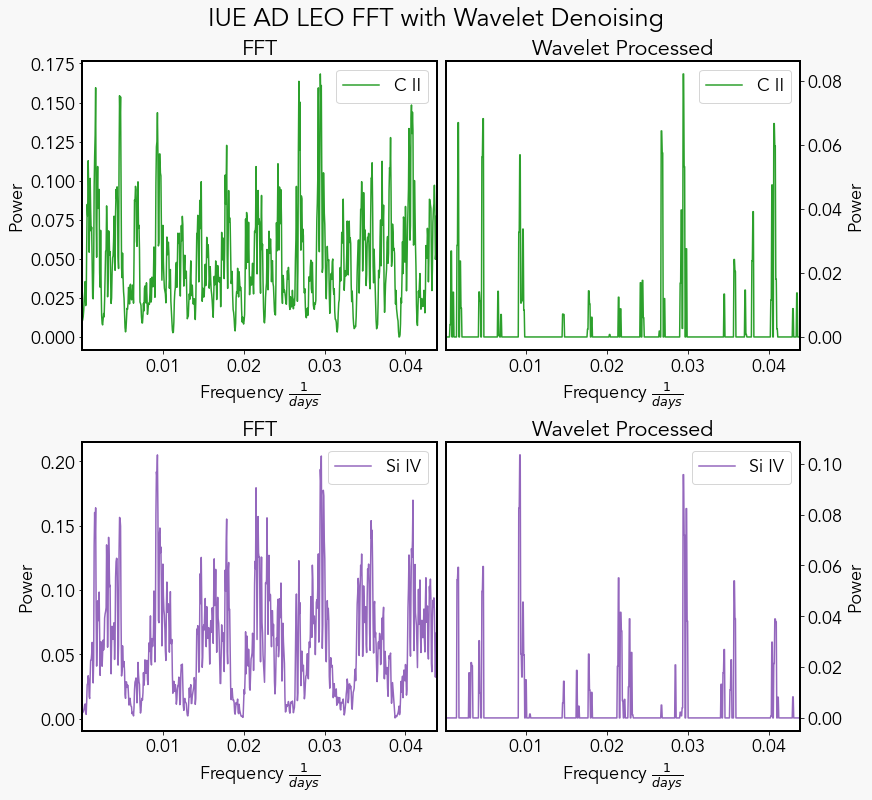

In [201]:
######################################################################################################################
# Wavelet Transform #

# fft_data[n] format:
# [0: name, 1: telescope, 2: spectral type, 3: freq_Si3, 4: power_Si3, 5: freq_N5, 6: power_N5, 7: freq_C2, 8: power_C2, 9: freq_Si4, 10: power_Si4]

# Scales flux so data loss is minimized
scale = 10e13

for n in range(len(fft_data)):
    wavelet_denoise_plot_folder = path + 'PLOTS/WAVELET-DENOISING/' + fft_data[n][2] + '_STARS/'
    w = 'haar'
    l = 1
    keep = 0.08
    
    # Generating wavelet decomposition coefficients from 1D power arrays
    coeffs_Si3 = pywt.wavedec(fft_data[n][4], wavelet=w, level=l)
    coeffs_N5 = pywt.wavedec(fft_data[n][6], wavelet=w, level=l)
    coeffs_C2 = pywt.wavedec(fft_data[n][8], wavelet=w, level=l)
    coeffs_Si4 = pywt.wavedec(fft_data[n][10], wavelet=w, level=l)
    
    # Reshaping coefficients into arrays
    coeff_arr_Si3, coeff_slices_Si3 = pywt.coeffs_to_array(coeffs_Si3)
    coeff_arr_N5, coeff_slices_N5 = pywt.coeffs_to_array(coeffs_N5)
    coeff_arr_C2, coeff_slices_C2 = pywt.coeffs_to_array(coeffs_C2)
    coeff_arr_Si4, coeff_slices_Si4 = pywt.coeffs_to_array(coeffs_Si4)
    
    # Obtains threshold value that keeps keep * 100% of coefficient values
    Csort_Si3 = np.sort(np.abs(coeff_arr_Si3.reshape(-1)))
    Csort_N5 = np.sort(np.abs(coeff_arr_N5.reshape(-1)))
    Csort_C2 = np.sort(np.abs(coeff_arr_C2.reshape(-1)))
    Csort_Si4 = np.sort(np.abs(coeff_arr_Si4.reshape(-1)))
    thresh_Si3 = Csort_Si3[int(np.floor((1 - keep) * len(Csort_Si3)))]
    thresh_N5 = Csort_N5[int(np.floor((1 - keep) * len(Csort_N5)))]
    thresh_C2 = Csort_C2[int(np.floor((1 - keep) * len(Csort_C2)))]
    thresh_Si4 = Csort_Si4[int(np.floor((1 - keep) * len(Csort_Si4)))]
    
    # Uses soft thresholding technique on coefficient array utilizing threshold values calculated
    coeff_arr_Si3 = pywt.threshold(coeff_arr_Si3, thresh_Si3, mode='soft')
    coeff_arr_N5 = pywt.threshold(coeff_arr_N5, thresh_N5, mode='soft')
    coeff_arr_C2 = pywt.threshold(coeff_arr_C2, thresh_C2, mode='soft')
    coeff_arr_Si4 = pywt.threshold(coeff_arr_Si4, thresh_Si4, mode='soft')
    
    # Rearranges filtered coefficient array into proper shape
    coeffs_filt_Si3 = pywt.array_to_coeffs(coeff_arr_Si3, coeff_slices_Si3, output_format='wavedec')
    coeffs_filt_N5 = pywt.array_to_coeffs(coeff_arr_N5, coeff_slices_N5, output_format='wavedec')
    coeffs_filt_C2 = pywt.array_to_coeffs(coeff_arr_C2, coeff_slices_C2, output_format='wavedec')
    coeffs_filt_Si4 = pywt.array_to_coeffs(coeff_arr_Si4, coeff_slices_Si4, output_format='wavedec')
    
    # Reconstruction of power arrays
    rec_Si3 = pywt.waverec(coeffs_filt_Si3, wavelet=w)
    rec_N5 = pywt.waverec(coeffs_filt_N5, wavelet=w)
    rec_C2 = pywt.waverec(coeffs_filt_C2, wavelet=w)
    rec_Si4 = pywt.waverec(coeffs_filt_Si4, wavelet=w)
    
    # Reshapes power arrays into proper sizing
    if (len(fft_data[n][3]) != len(rec_Si3)):
        rec_Si3 = rec_Si3[np.abs(len(fft_data[n][3]) - len(rec_Si3)):]
    if (len(fft_data[n][5]) != len(rec_N5)):
        rec_N5 = rec_N5[np.abs(len(fft_data[n][5]) - len(rec_N5)):]
    if (len(fft_data[n][7]) != len(rec_C2)):
        rec_C2 = rec_C2[np.abs(len(fft_data[n][7]) - len(rec_C2)):]
    if (len(fft_data[n][9]) != len(rec_Si4)):
        rec_Si4 = rec_Si4[np.abs(len(fft_data[n][9]) - len(rec_Si4)):]
    
    # Plot side by side of FFT plots -> FFT + Wavelet Denoising plots
    if fft_data[n][1] == 'HST':
        fig, axs = plt.subplots(4, 2, figsize=(12,11), constrained_layout = True)
        fig.suptitle(f'{fft_data[n][1]} {fft_data[n][0]} FFT with Wavelet Denoising', fontsize=25)
        fig.patch.set_facecolor('#f8f8f8')

        axs[0, 0].plot(fft_data[n][3], fft_data[n][4], color=colors(0), label='Si III')
        axs[0, 0].legend()
        axs[0, 0].set_title('FFT')
        axs[0, 0].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[0, 0].set_xlim([min(fft_data[n][3]), max(fft_data[n][3])])
        axs[0, 1].plot(fft_data[n][3], rec_Si3, color=colors(0), label='Si III')
        axs[0, 1].legend()
        axs[0, 1].yaxis.set_label_position("right")
        axs[0, 1].yaxis.tick_right()
        axs[0, 1].set_title('Wavelet Processed')
        axs[0, 1].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[0, 1].set_xlim([min(fft_data[n][3]), max(fft_data[n][3])])
        axs[1, 0].plot(fft_data[n][5], fft_data[n][6], color=colors(1), label='N V')
        axs[1, 0].legend()
        axs[1, 0].set_title('FFT')
        axs[1, 0].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[1, 0].set_xlim([min(fft_data[n][5]), max(fft_data[n][5])])
        axs[1, 1].plot(fft_data[n][5], rec_N5, color=colors(1), label='N V')
        axs[1, 1].legend()
        axs[1, 1].yaxis.set_label_position("right")
        axs[1, 1].yaxis.tick_right()
        axs[1, 1].set_title('Wavelet Processed')
        axs[1, 1].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[1, 1].set_xlim([min(fft_data[n][5]), max(fft_data[n][5])])
        axs[2, 0].plot(fft_data[n][7], fft_data[n][8], color=colors(2), label='C II')
        axs[2, 0].legend()
        axs[2, 0].set_title('FFT')
        axs[2, 0].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[2, 0].set_xlim([min(fft_data[n][7]), max(fft_data[n][7])])
        axs[2, 1].plot(fft_data[n][7], rec_Si3, color=colors(2), label='C II')
        axs[2, 1].legend()
        axs[2, 1].yaxis.set_label_position("right")
        axs[2, 1].yaxis.tick_right()
        axs[2, 1].set_title('Wavelet Processed')
        axs[2, 1].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[2, 1].set_xlim([min(fft_data[n][7]), max(fft_data[n][7])])
        axs[3, 0].plot(fft_data[n][9], fft_data[n][10], color=colors(3), label='Si IV')
        axs[3, 0].legend()
        axs[3, 0].set_title('FFT')
        axs[3, 0].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[3, 0].set_xlim([min(fft_data[n][9]), max(fft_data[n][9])])
        axs[3, 1].plot(fft_data[n][9], rec_N5, color=colors(3), label='Si IV')
        axs[3, 1].legend()
        axs[3, 1].yaxis.set_label_position("right")
        axs[3, 1].yaxis.tick_right()
        axs[3, 1].set_title('Wavelet Processed')
        axs[3, 1].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[3, 1].set_xlim([min(fft_data[n][9]), max(fft_data[n][9])])
        
        # Save plot
        plt.savefig(wavelet_denoise_plot_folder + 'HST_' + fft_data[n][0] + '.png', transparent=False, bbox_inches='tight')
        
        # Show plot
        plt.show()
        
        # Close plot
#         plt.close()
    else:
        fig, axs = plt.subplots(2, 2, figsize=(12,11), constrained_layout = True)
        fig.suptitle(f'{fft_data[n][1]} {fft_data[n][0]} FFT with Wavelet Denoising', fontsize=25)
        fig.patch.set_facecolor('#f8f8f8')

        axs[0, 0].plot(fft_data[n][7], fft_data[n][8], color=colors(2), label='C II')
        axs[0, 0].legend()
        axs[0, 0].set_title('FFT')
        axs[0, 0].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[0, 0].set_xlim([min(fft_data[n][7]), max(fft_data[n][7])])
        axs[0, 1].plot(fft_data[n][7], rec_C2, color=colors(2), label='C II')
        axs[0, 1].legend()
        axs[0, 1].yaxis.set_label_position("right")
        axs[0, 1].yaxis.tick_right()
        axs[0, 1].set_title('Wavelet Processed')
        axs[0, 1].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[0, 1].set_xlim([min(fft_data[n][7]), max(fft_data[n][7])])
        axs[1, 0].plot(fft_data[n][9], fft_data[n][10], color=colors(3), label='Si IV')
        axs[1, 0].legend()
        axs[1, 0].set_title('FFT')
        axs[1, 0].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[1, 0].set_xlim([min(fft_data[n][9]), max(fft_data[n][9])])
        axs[1, 1].plot(fft_data[n][9], rec_Si4, color=colors(3), label='Si IV')
        axs[1, 1].legend()
        axs[1, 1].yaxis.set_label_position("right")
        axs[1, 1].yaxis.tick_right()
        axs[1, 1].set_title('Wavelet Processed')
        axs[1, 1].set(xlabel=r'Frequency $\frac{1}{days}$', ylabel='Power')
        axs[1, 1].set_xlim([min(fft_data[n][9]), max(fft_data[n][9])])

        # Save plot
        plt.savefig(wavelet_denoise_plot_folder + 'IUE_' + fft_data[n][0] + '.png', transparent=False, bbox_inches='tight')
        
        # Show plot
        plt.show()
        
        # Close plot
#         plt.close()